In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage
from scipy import interpolate
import scipy.misc
import scipy.signal
from matplotlib import cm
import math
from PIL import Image
import pandas as pd
from numpy.fft import fft2, fftshift, ifftshift
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/MIA_Final_Project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1SvB1VAh73sq76RVpYlFopJXnaAVurzD4/MIA_Final_Project


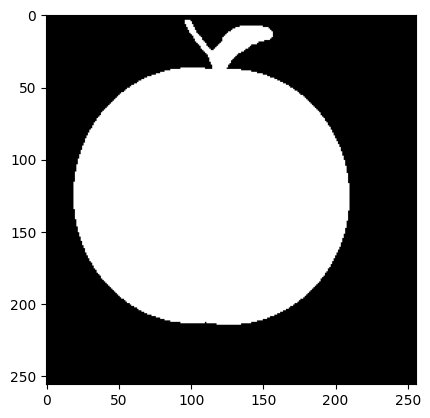

In [3]:
image = plt.imread('original/apple-1.gif')
plt.set_cmap("gray")
plt.imshow(image)

In [4]:
def plot_descriptors(d):
  # Inverse Fourier Transform to get back contour points
  reconstructed_contour = np.fft.ifft(d)
  # Extract the real and imaginary parts to plot
  x_reconstructed = reconstructed_contour.real
  y_reconstructed = reconstructed_contour.imag
  plt.figure(figsize=(5, 5))
  plt.plot(x_reconstructed, -1*y_reconstructed, 'r-', label='Reconstructed Contour')
  plt.title('Reconstructed Contour from Phase')
  plt.axis('equal')
  plt.show()

# Refer step # from the original paper

In [5]:
def find_contour(image):
  '''
  Calculate contour of image, then translated and scale
  Input parameter: image as a 2D ndarray
  Returns: an Nx1 array of the scaled and translated contour, where
           each contour is stored as Z = x + j * y
  Returns: a, fourier coefficients
  '''

  contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  largest_contour = max(contours, key=cv2.contourArea)
  # reshape the contour into a Nx2 array
  P = largest_contour.reshape(largest_contour.shape[0], largest_contour.shape[-1])
  Z = P[:,0] + 1j*P[:,1]
  Zc = np.mean(Z)
  # a = np.fft.fft(Z)
  a = np.zeros_like(Z)*1j
  N = Z.shape[0]
  for k in range(N):
    sum = 0
    for n in range(N):
      sum += Z[n] * np.exp(-1j*2*np.pi*n*k/N)
    a[k] = sum/N

  Sc = np.sum( np.abs(a[1:]) )
  return (Z - Zc) / Sc, a, Sc

# step 2
def sort_coef(a, M=30):
  '''
  Step 2 of the algorithm: assume we don't sort
  Inputs: Fourier coefficients and number of fourier coefficients we want to keep
  Return: R_ind, a list of the first R largest coefficients
  '''
  a = np.abs(a[1:])
  am = np.concatenate((a[-M//2:], a[1:M//2+1]))
  M_ind = am.argsort()[::-1]
  # M_ind = M_ind[:M]
  M_ind = np.concatenate((M_ind[-M//2:], M_ind[1:M//2+1]))
  am = a[M_ind]
  target = .95 * np.sum(am)
  R = []
  current_sum = 0

  for index in M_ind:
      current_sum += am[index]
      R.append(index)
      if current_sum > target:
          break

  return np.array(R)

# step 3 and step 4
def derotate_all_contours(Z, a, Sc,M=30):
  '''
  Input: Nx1 array of the contour, assume we don't actually sort
  Input: a_M, a list
  Output: NxN array of the contour, calculated using each point as the starting point
  Output: NxM array of coefficient
  Output : a0
  '''
  N = Z.shape[0]
  contours = np.ones((N, N))*1j
  coefficients = np.ones((N, M))*1j
  ang = np.angle(Z[0])

  contours[0, :] = np.exp(-1j * ang) * Z
  a0 = np.exp(-1j * ang) * Sc * a
  coefficients[0, :] = np.concatenate((a0[-M//2:], a0[1:M//2+1]))
  for m in range(1, N):
    c = []
    Zm = np.concatenate((Z[m:], Z[:m]))
    ang_m = np.angle(Zm[0])
    Z = np.exp(-1j * ang_m) * Zm
    contours[m, :] = Z
    for k in range(-M//2, M//2+1):
      if k == 0:
        continue
      else:
        c.append(np.exp(-1j * ang_m) * np.exp(2j*np.pi*m*k/N) * np.exp(1j *ang) * a0[k])
    coefficients[m,:] = np.array(c).T
  return contours, coefficients, a0

 # step 5
def objective_function(coefficients, R_ind):
  '''
  Input:
          coefficients: A 2D array where each row contains complex coefficient
          R_ind : An array of indices specifying which coefficients in each row should be considered in the summation.

  Output: f[m]
  '''
  f = np.ones((coefficients.shape[0], 1))
  for m in range(coefficients.shape[0]):
    am = coefficients[m, :]
    f[m] = 2 * np.sum( np.abs( np.imag(am[R_ind])) )
  return f

In [6]:
# step 6 and 7
def sort_points_and_find_local_minima(fm, Q = 6):
  '''
  sort pairs (m, f(m)) in ascending order
  return: Q best local minima
  '''
  local_minima = []
  for i in range(1, len(fm)-1):
    if fm[i - 1] > fm[i] and fm[i] < fm[i + 1]:
      local_minima.append((fm[i][0], i))

  sorted_lm = sorted(local_minima)
  lm = np.array(sorted_lm)
  val = min(Q, len(local_minima))
  lm = lm[:val, :]

  return lm[:, 1]


In [7]:
# step 8 and 9
def interpolate_phase_function(lm_index, Z, a0, N, R_ind, Q = 6, M = 30, S=1, delta_m = 0.05):
    '''
    compute finer pseudomirrror points
    return: new coefficients, ms_fine: 1D array (best Q local minima)
    '''
    arg_Z0 = np.angle(Z[0])
    coefficients = np.ones((N, M), dtype=np.complex128)

    for lm_idx in lm_index:
        x = np.arange(lm_idx - S, lm_idx + S + delta_m, delta_m)
        y = np.angle(Z[x.astype(int)])
        g = interpolate.interp1d(x, y, kind='linear', fill_value='extrapolate')

    for m in range(1, N):
      c = []
      Zm = np.concatenate((Z[m:], Z[:m]))
      ang_m = np.angle(Zm[0])
      for k in range(-M//2, M//2+1):
        if k == 0:
            continue
        else:
          c.append(np.exp(-1j * g(m)) * np.exp(2j*np.pi*m*k/N) * \
              np.exp(1j * arg_Z0) * a0[k])
      coefficients[m,:] = np.array(c).T

    f = objective_function(coefficients, R_ind)
    ms_fine = sort_points_and_find_local_minima(f)

    return coefficients, ms_fine

In [8]:
# step 10
def get_pifd_descriptors(coefficients, ms_fine_index):
  descriptors = []
  for i in ms_fine_index:
    descriptors.append(coefficients[i])
  return np.array(descriptors)

In [9]:
# aggregate all previous steps
def find_pifd(image, Q, M):
  Z, a, Sc = find_contour(image)
  R = sort_coef(a, M)
  new_Z, new_a, a0 = derotate_all_contours(Z, a, Sc,M)
  N = Z.shape[0]
  f = objective_function(new_a, R)
  lm = sort_points_and_find_local_minima(f, Q)
  lm_index = np.array([int(i) for i in lm])
  coefficients, ms_fine = interpolate_phase_function(lm_index, Z, a0, N, R, M , S=1, delta_m = 0.05)
  ms_fine_index = np.array([int(i) for i in ms_fine])
  pifd = get_pifd_descriptors(coefficients, ms_fine_index)
  return pifd


# Now test on the apple image

In [10]:
pifd = find_pifd(image, Q=6, M=30)

In [11]:
pifd.shape

(6, 30)

In [12]:
pifd

array([[ 4.71749475e+01+5.28059808e+01j,  7.24404852e+01-5.32540615e+01j,
        -9.25941391e+01-1.28560475e+02j, -1.88849995e+02+6.93176589e+01j,
         4.90596295e+00+1.69784292e+02j,  1.70328647e+02+8.34683555e+01j,
         1.17102418e+02-6.41909473e+01j,  8.96755077e+01-4.37899693e+01j,
         1.07420395e+02-1.40413821e+02j,  4.36264398e+00-7.27128318e+02j,
        -5.03764515e+02-1.86354997e+02j, -3.61361208e+02+3.27591608e+02j,
        -2.06033396e+02-4.10862028e+02j, -3.23786207e+03-2.96431575e+01j,
         7.03910621e+03-1.46182100e+04j, -1.76140019e+03+4.63310692e+02j,
        -2.22332816e+02+1.22109235e+03j,  4.14303326e+02+3.17125205e+02j,
        -3.92213156e+01+1.72784483e+02j,  1.40658345e+02+3.27264571e+02j,
         4.16425557e+02+4.75355674e+01j,  2.36925536e+02-4.21649089e+02j,
        -2.06783353e+02-2.82706613e+02j, -2.66559787e+02+1.09020279e+02j,
         3.47640470e+01+8.98750052e+01j,  1.08764696e+01-6.68235266e+01j,
        -1.30259952e+02-1.99963525e+00

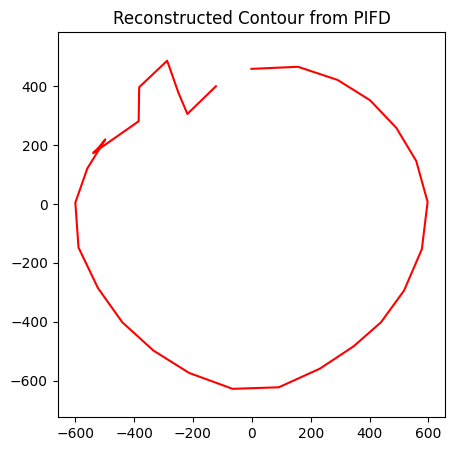

In [13]:
# Inverse Fourier Transform to get back contour points
reconstructed_contour = np.fft.ifft(np.fft.fftshift(pifd[3]))
# Extract the real and imaginary parts to plot
x_reconstructed = reconstructed_contour.real
y_reconstructed = reconstructed_contour.imag
plt.figure(figsize=(5, 5))
plt.plot(x_reconstructed, -1*y_reconstructed, 'r-', label='Reconstructed Contour')
plt.title('Reconstructed Contour from PIFD')
plt.axis('equal')
plt.show()

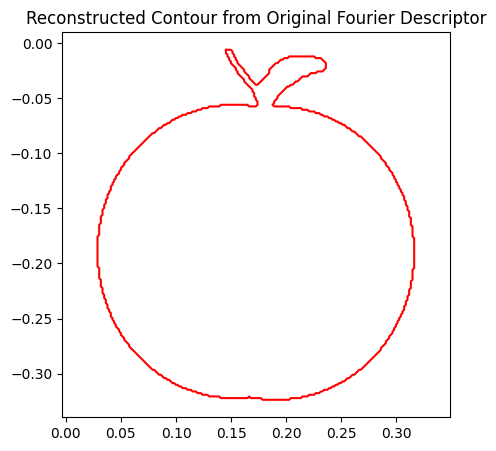

In [14]:
  # Inverse Fourier Transform to get back contour points
  a = find_contour(image)[1]
  reconstructed_contour = np.fft.ifft(a)
  # Extract the real and imaginary parts to plot
  x_reconstructed = reconstructed_contour.real
  y_reconstructed = reconstructed_contour.imag
  plt.figure(figsize=(5, 5))
  plt.plot(x_reconstructed, -1*y_reconstructed, 'r-', label='Reconstructed Contour')
  plt.title('Reconstructed Contour from Original Fourier Descriptor')
  plt.axis('equal')
  plt.show()